# **Drainage Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 01/21/2022

Date Modified: 01/21/2022

In [1]:
#Import necessary packages

import pandas as pd #to work with data arrays
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from sklearn import metrics #to find r2 values from regression
!pip install pymannkendall
import pymannkendall as mk #used to perform mann-kendall stationarity test
from sklearn.cluster import KMeans #to cluster using kmeans

In [2]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
datasets/  pod_pou_lulcc/


In [4]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###

all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/fulltime_individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DataDate'], index_col=['DataDate'])
  all_files.append(df) #appends dataframes to one file list

In [5]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Select only the diversions known to serve irrigation districts
#  Will remove reservoir, natural flow, and return flow data

drain_list = [] #create a list to store the diversion data frame in

for i in range(len(all_files)):
  sel_data = all_files[i]
  data_type = sel_data['DiversionTypeDescription'][1]
  if data_type == ('Drain') or data_type == ('Flow'):
    drain_list.append(sel_data)
  else:
    None

## Get list of names for all the drains
names = []

for i in drain_list:
  canal = i['DiversionName']
  names.append(canal[0])

## Select diversions with data from 1987-2021 for study
## All else is discarded

fullextent_list = []

for i in range(len(drain_list)):
  sel_data = drain_list[i]
  oldest_year = sel_data.index.year[0]
  if oldest_year <= 1987:
    fullextent_list.append(sel_data)
  else:
    None

## Crop each time series with full extent range to desired time series

croppped_data = []

for i in fullextent_list:
  sel_data = i
  if sel_data.index.year[-1]>=1987:
    crop = sel_data.truncate(before='1987-01-01')
    croppped_data.append(crop)
  else:
    None

## Fill in any missing winter values with 0 starting at 1987-01-01

dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

drains_lbrb = []

for i in range(len(croppped_data)):
  canal = croppped_data[i] #selects the specific diversion dataframe
  canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
  canal = canal.drop(labels=0, axis=1) #dropes the series column
  canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
  canal = canal.asfreq('d') #fill each daily value
  canal['CFS'] = canal['CFS'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
  canal['DiversionName'] = canal['DiversionName'].fillna(names[i]) #fills Nan diversion name values
  drains_lbrb.append(canal)

drains_acre = []

for i in range(len(drains_lbrb)):
  canal = drains_lbrb[i]
  canal['Acre_feet'] = canal['CFS']*86400/43559.9
  drains_acre.append(canal)

drains = []

flows = ['BOISE RIVER AT ARROWROCK DAM', 'BOISE RIVER AT GLENWOOD BRIDGE', 'BOISE RIVER BELOW DIVERSION DAM',
         'BOISE RIVER NEAR MIDDLETON', 'BOISE RIVER NEAR TWIN SPRINGS', 'MASON CREEK',
         'MORES CREEK ABOVE ROBIE CREEK NEAR ARROWROCK DAM', 'SOUTH FORK BOISE RIVER AT ANDERSON RANCH DAM',
         'SOUTH FORK BOISE RIVER NEAR FEATHERVILLE', 'WILLOW CREEK AT MIDDLETON']

for i in range(len(drains_acre)):
  canal = drains_acre[i]
  if canal['DiversionName'].iloc[0] in flows:
    None
  else: 
    drains.append(canal)


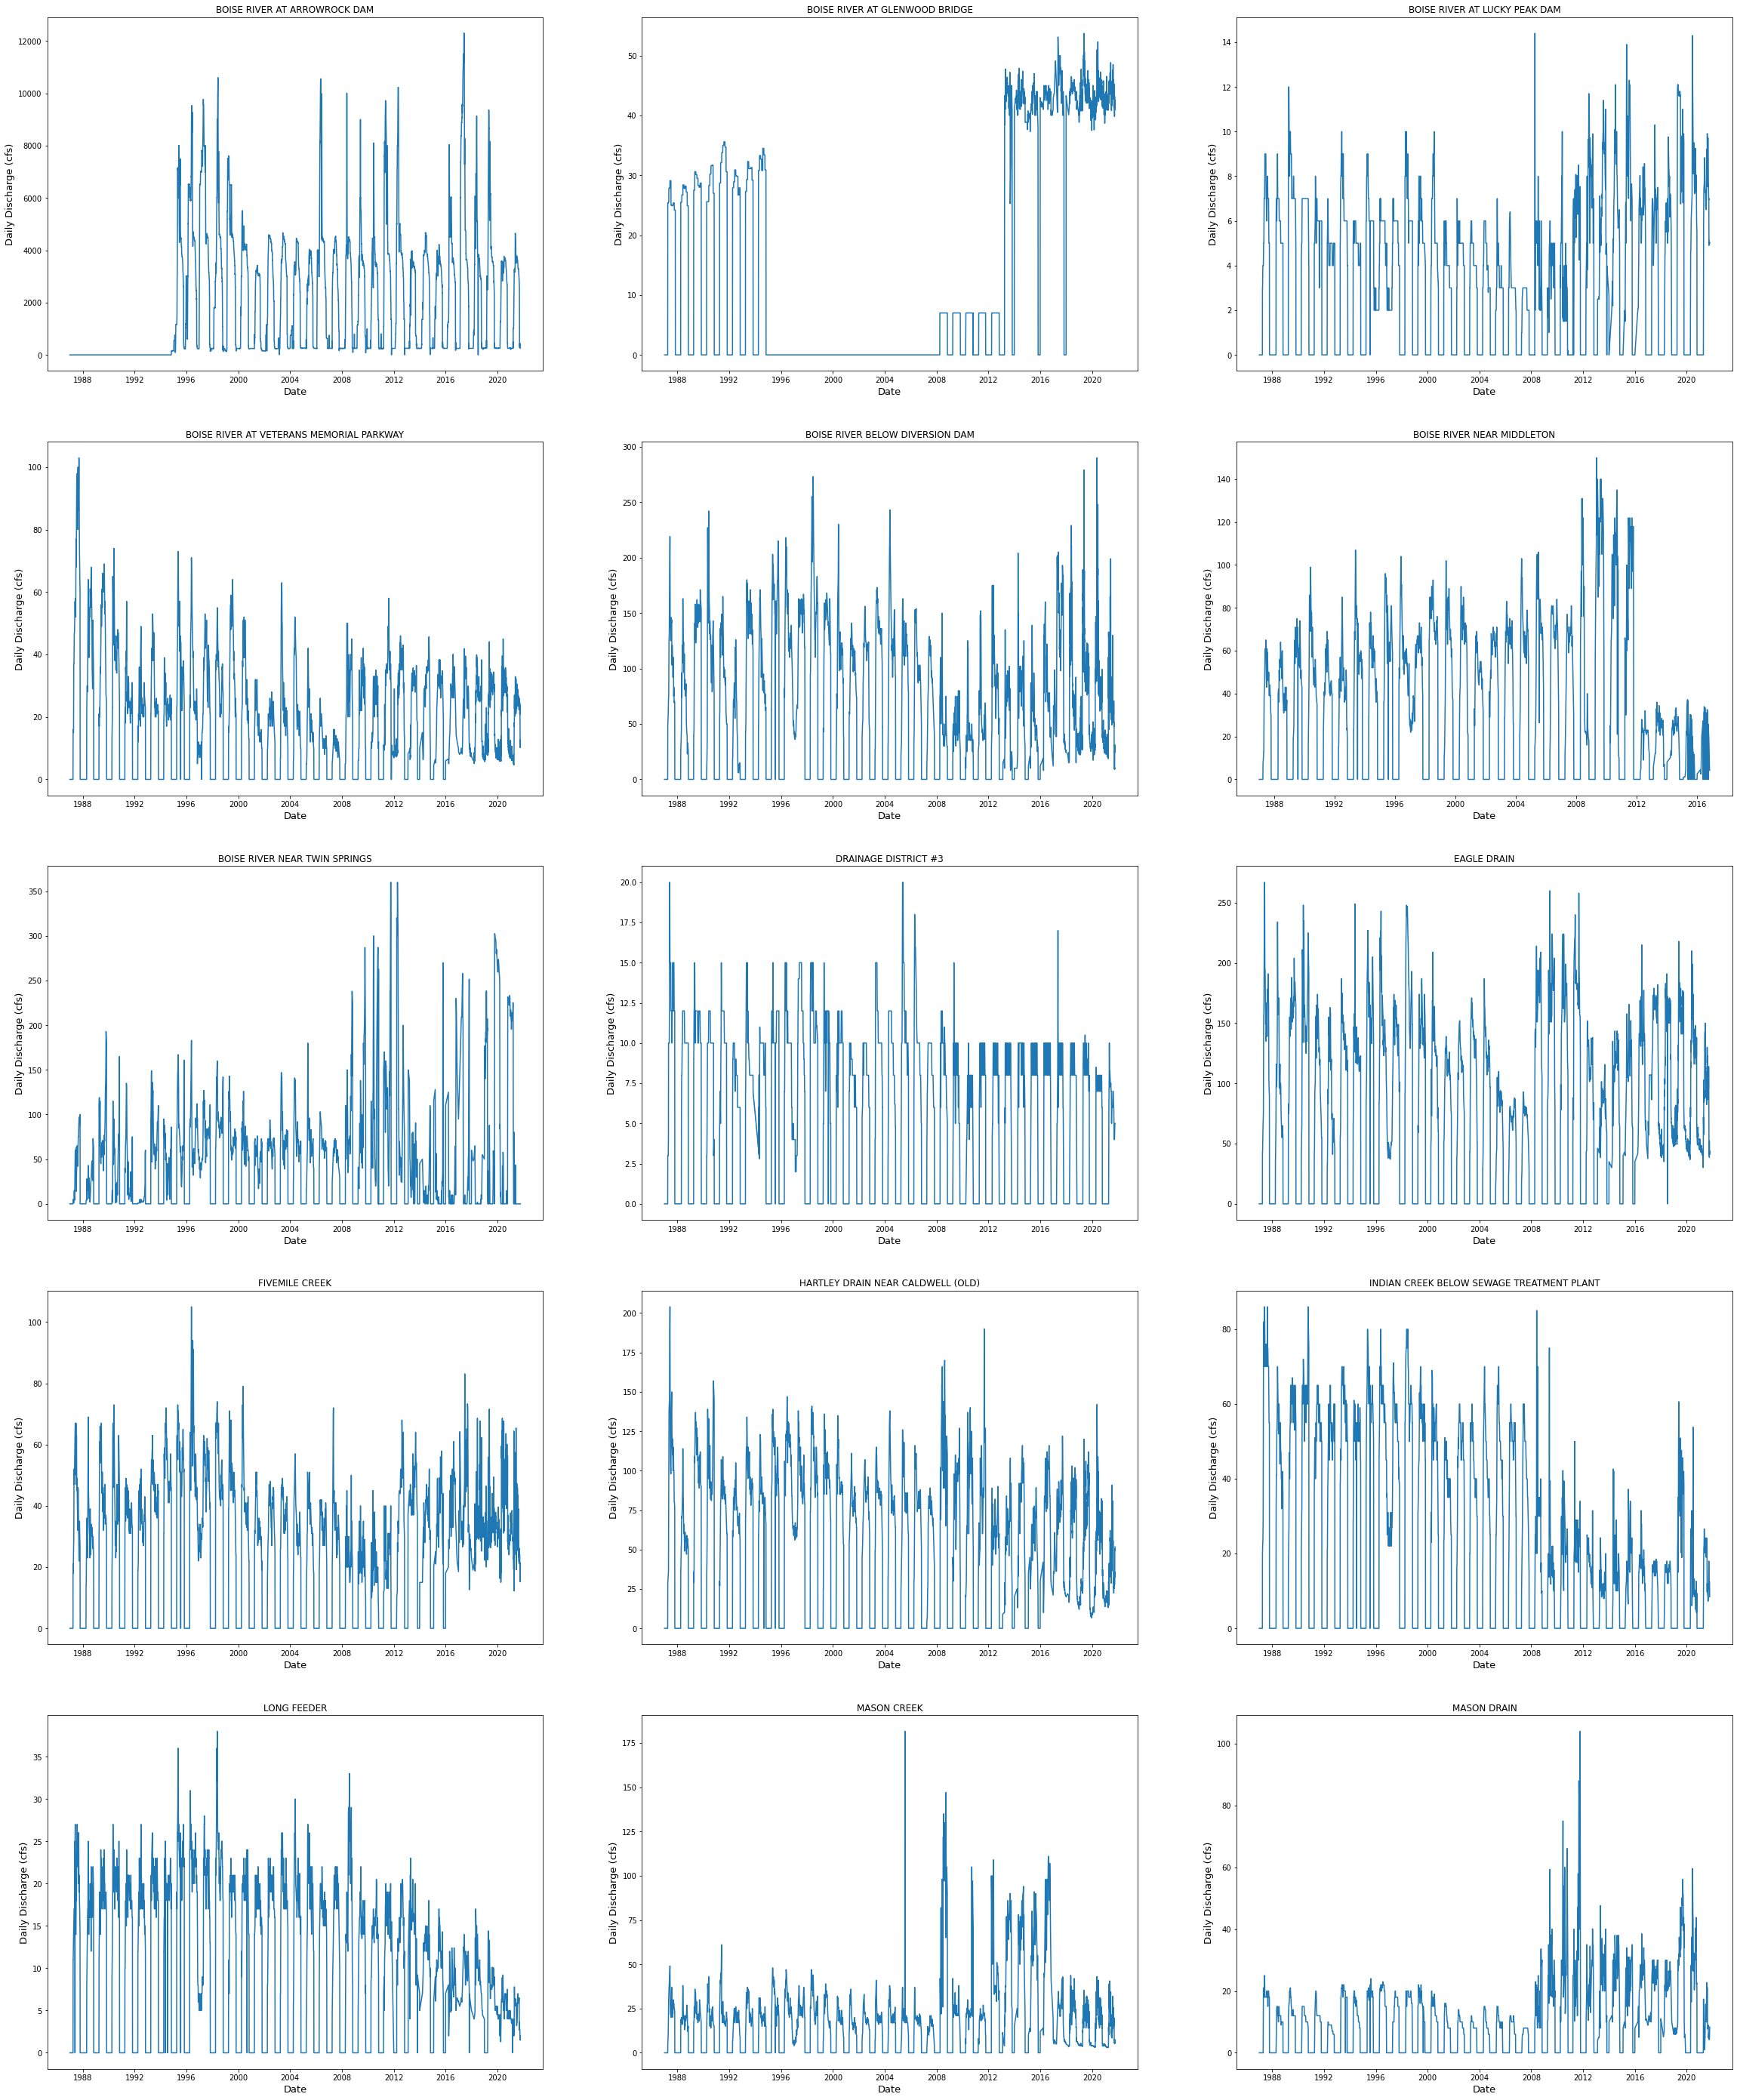

In [6]:
## PLOT THE RAW DATA TO VISUALLY ANALYZE TRENDS AND SEASONALITY

i,j = 0,0
plot_row = 3 #number of plots per row in figure
figure, ax = plt.subplots(5, plot_row, figsize=(40,50)) #create the figure

for n in range(len(drains)): #run a for loop to add all plots to figure
  canal_data = drains[n] #takes an individual diversion point dataframe
  ax[i][j].plot(canal_data.index, canal_data['CFS'])
  ax[i][j].set_ylabel('Daily Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Date', size=13)
  ax[i][j].title.set_text(names[n])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/drain_figs/rawdata.png')


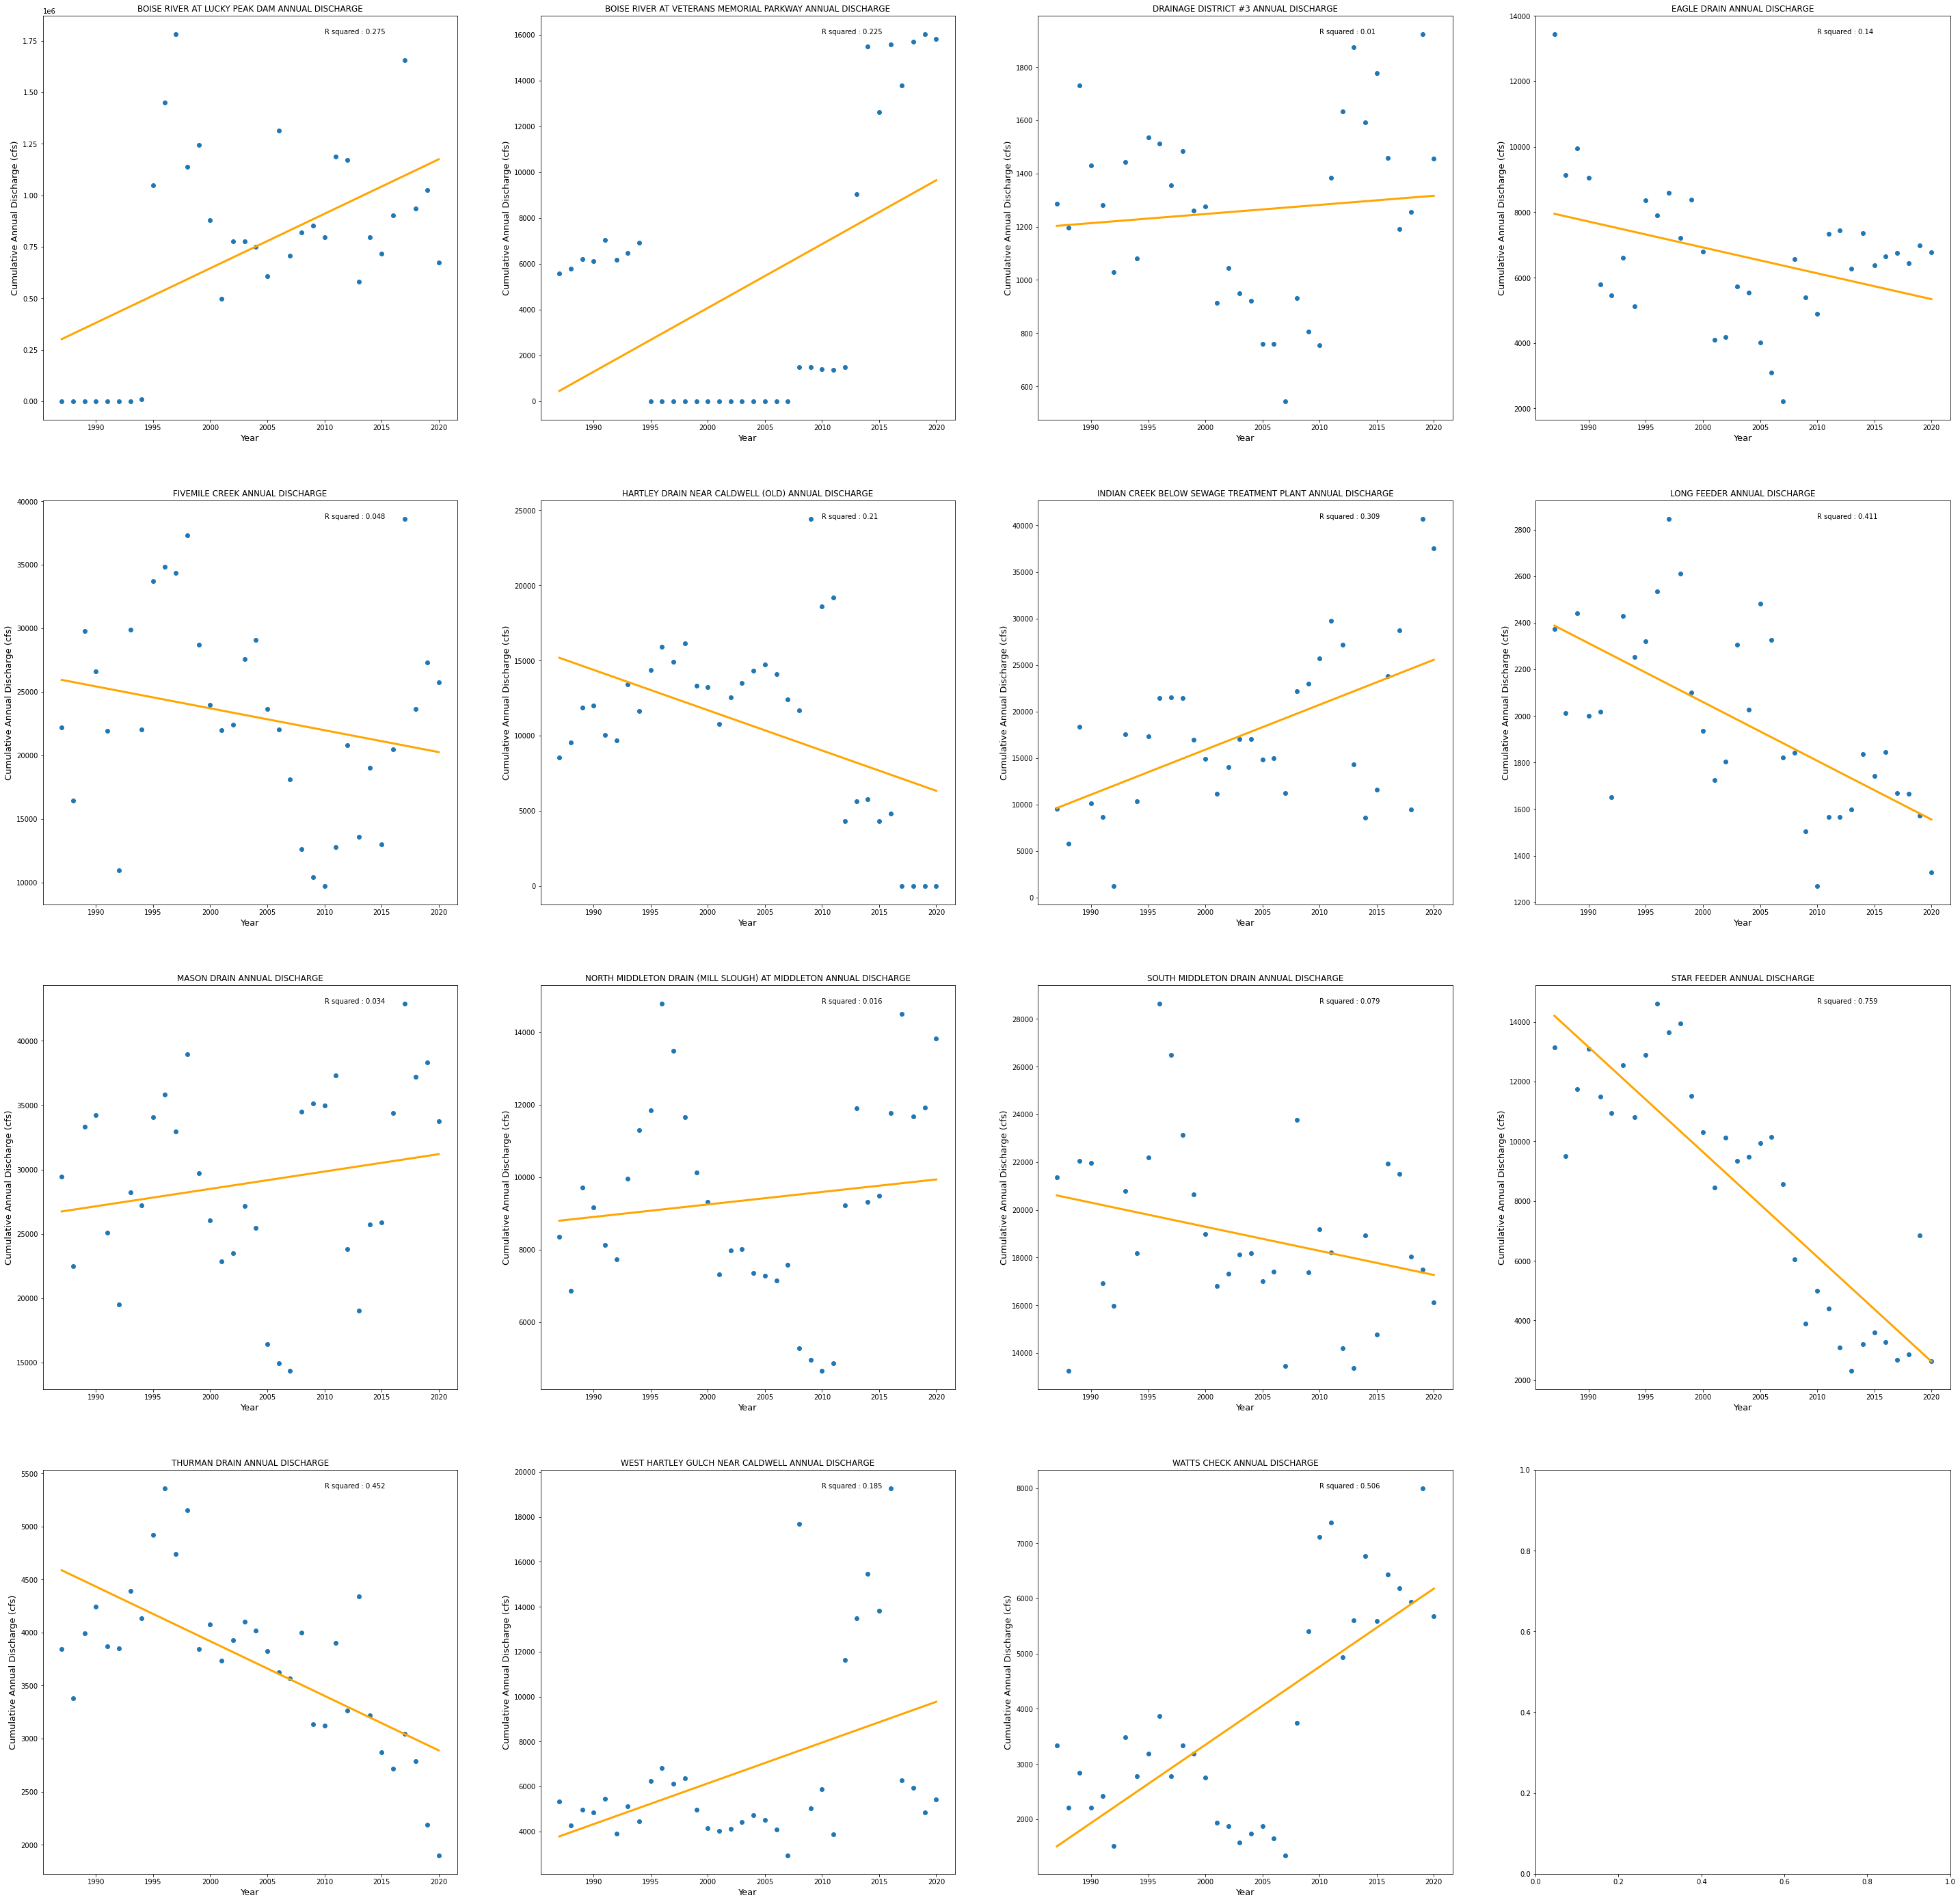

In [7]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

years = np.arange(1987, 2021, 1)
totals = np.empty((len(years), len(drains)))
totals_df = []

for i in range(len(drains)):
  tot_list = []
  for y in range(len(years)):
    sub_canal = drains[i]
    Ix = sub_canal.index.year == years[y] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    totals[y][i] = sum(subset_year['CFS']) #sum the total discharge throughout the year
    tot_list.append([years[y], sub_canal['DiversionName'][0], sum(subset_year['CFS'])])
  tot_todf = pd.DataFrame(tot_list, columns = ['Year', 'Diversion Name', 'Total'])
  totals_df.append(tot_todf)

## CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(drains)))
rsquared = np.empty(len(drains))

for i  in range(len(drains)):
  model = np.polyfit(years, totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(totals[:,i], regression[:,i]) #compares correlation of model to true values


## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 4 #number of plots per row in figure
figure, ax = plt.subplots(4, plot_row, figsize=(50,50)) #create the figure

for n in range(len(drains)): #run a for loop to add all plots to figure
  canal = drains[n]
  canal_data = totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(canal['DiversionName'][0]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2010, np.max(totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/drain_figs/totals.png')

In [8]:
## CALCULATE BASIC VOLUME STATISTICS ##

stats = []

for i in range(len(drains)):
  canal = drains[i]
  avg = np.mean(canal['CFS'][canal['CFS'] != 0])
  std_dev = np.std(canal['CFS'][canal['CFS'] != 0])
  avg_withzero = np.mean(canal['CFS'])
  std_withzero = np.std(canal['CFS'])
  coeff_var = std_dev/avg
  coeff_var_withzero = std_withzero/avg_withzero
  maximum = np.max(canal['CFS'])
  minimum = np.min(canal['CFS'][canal['CFS'] != 0])
  stats.append([canal['DiversionName'][0], avg, std_dev, coeff_var, maximum, minimum, avg_withzero, std_withzero, coeff_var_withzero])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Mean', 'Standard_dev', 
                                            'Coefficient_Variation', 'Maximum', 'Minimum', 
                                            'Mean_ZeroValues', 'Standard_dev_ZeroValues',
                                            'Coefficient_ZeroValues'])


display(base_stats)
base_stats.to_csv('datasets/diversion_timeseries/drain_figs/stats.csv')



,DiversionName,Mean,Standard_dev,Coefficient_Variation,Maximum,Minimum,Mean_ZeroValues,Standard_dev_ZeroValues,Coefficient_ZeroValues
0,BOISE RIVER AT LUCKY PEAK DAM,2610.919904,2433.879569,0.932192,12293.87,1.00,2022.676752,2403.947505,1.188498
1,BOISE RIVER AT VETERANS MEMORIAL PARKWAY,32.350308,13.639601,0.421622,53.72,1.17,14.480347,18.494220,1.277195
2,DRAINAGE DISTRICT #3,5.554769,2.320308,0.417714,14.40,0.01,3.475065,3.255032,0.936682
3,EAGLE DRAIN,26.323492,15.538182,0.590278,103.00,1.00,18.192076,17.742106,0.975266
4,FIVEMILE CREEK,92.667441,51.481465,0.555551,290.00,6.00,63.079222,60.584678,0.960454
5,HARTLEY DRAIN NEAR CALDWELL (OLD),53.711501,28.173984,0.524543,150.00,1.00,33.568456,34.238298,1.019955
6,INDIAN CREEK BELOW SEWAGE TREATMENT PLANT,79.374855,64.130537,0.807945,360.00,0.13,48.550942,63.341509,1.304640
7,LONG FEEDER,9.097280,2.813828,0.309304,20.00,0.14,5.368276,4.968952,0.925614
8,MASON DRAIN,116.511797,49.900601,0.428288,267.00,15.00,79.218483,68.171574,0.860551
9,NORTH MIDDLETON DRAIN (MILL SLOUGH) AT MIDDLETON,37.849324,13.354991,0.352846,105.00,1.67,25.773176,20.801215,0.807088


In [35]:
## ----------------------- ##
## CALCULATE ANNUAL TOTALS ##
## ----------------------- ##

df = pd.concat(drains)

tot = df.groupby([df.index.year,'DiversionName']).sum(['Acre_feet']).drop('HydrologyID', axis=1)   \
      .sort_values('DiversionName').reset_index().rename(columns={'level_0':'Year'}).sort_values(['DiversionName','Year'])  \
      .reset_index().drop('index',axis=1)


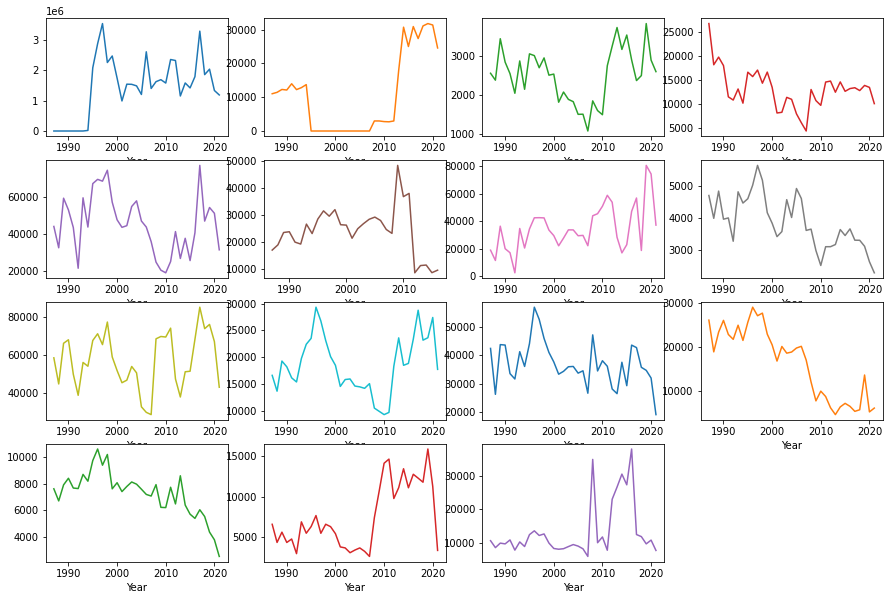

In [39]:
## ----------- ##
## PLOT TOTALS ##
## ----------- ##

df_plot = tot.pivot(index='Year', columns='DiversionName', values='Acre_feet')  \
          .reset_index() #pivot plot so each column is the name of the diversion with the 
          # values as the total annual acre-ft

df_plot.plot(kind='line', x='Year', layout=(4,4), subplots=True, figsize=(15,10), legend=False,
             sharey=False, sharex=False)
plt.show()

IndexError: ignored

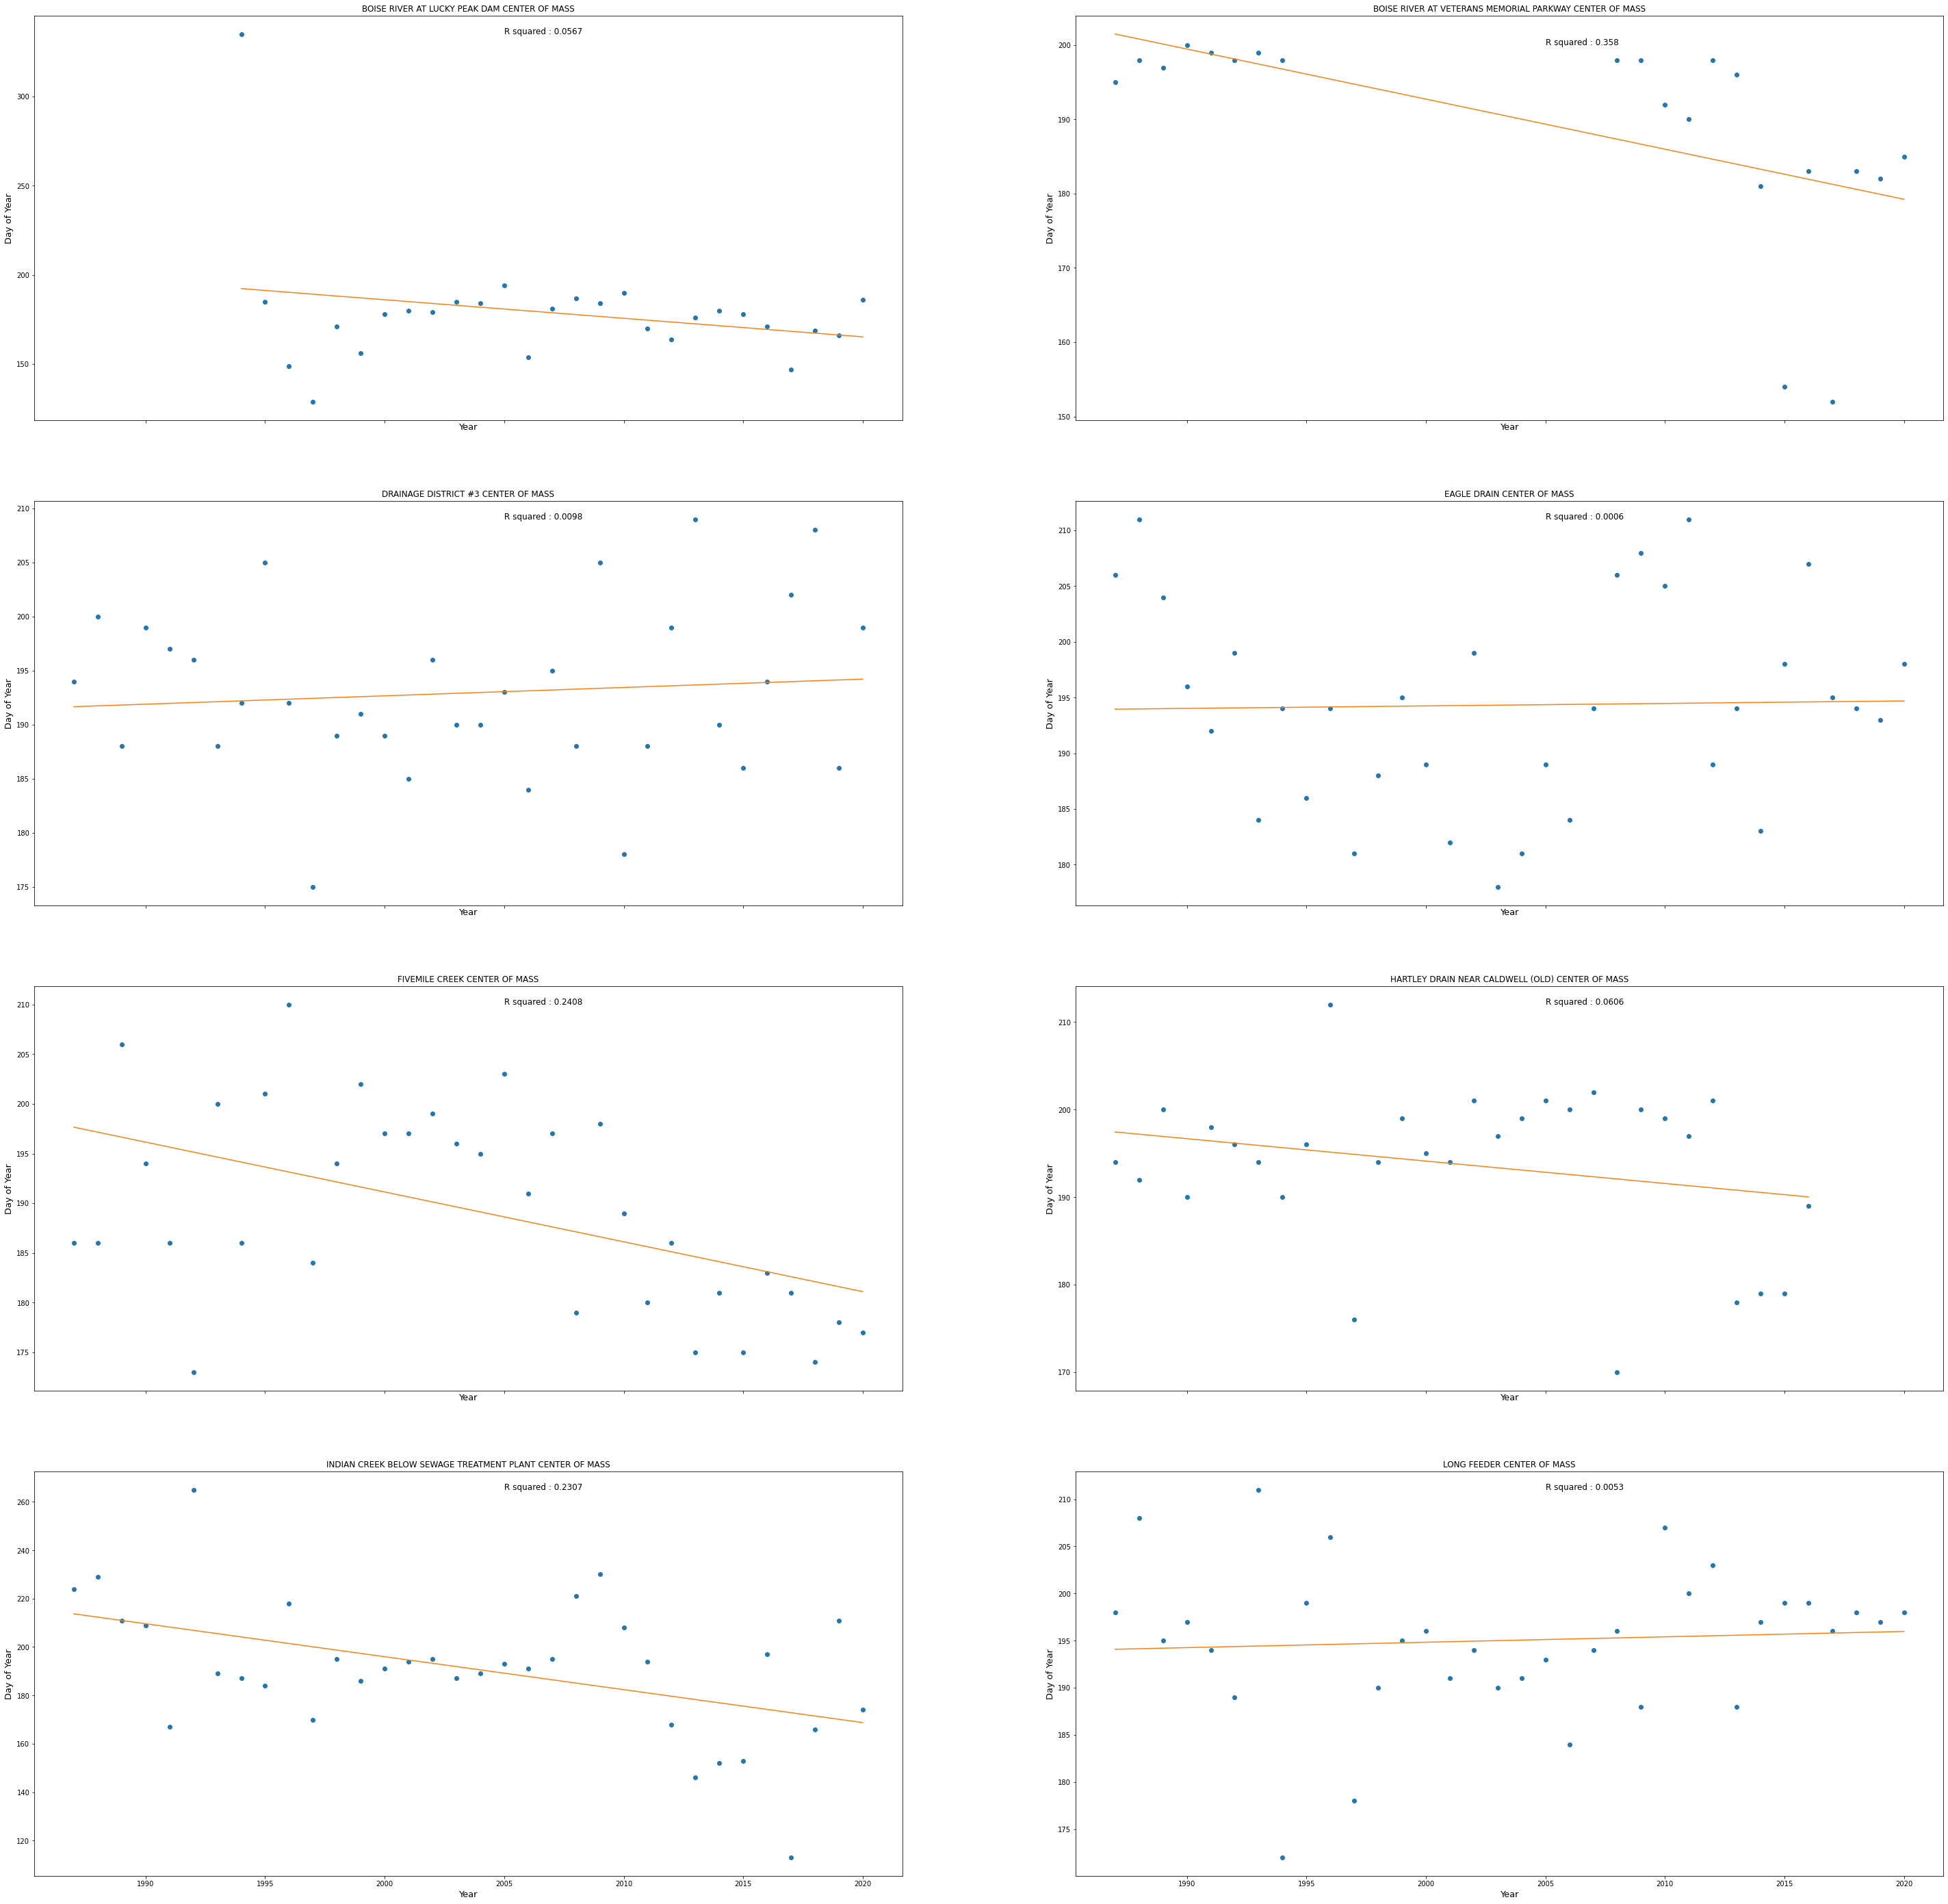

In [10]:
## FIND THE CENTER OF MASS OF THE IRRIGATION SEASON ##

centroid_df = []

for n in range(len(drains)):
  cent_list = []
  for i in range(len(years)):
    canal = drains[n]
    tots = totals_df[n]
    year = canal[canal.index.year == years[i]]
    tot_year = int(tots['Total'][tots['Year'] == years[i]])
    if tot_year == 0:
      None
    else:
      cent = round(np.sum(year.index.dayofyear*year['CFS'])/np.sum(year['CFS']))
      cent_list.append([years[i], canal['DiversionName'][0], cent])
  cent_todf = pd.DataFrame(cent_list, columns = ['Year', 'DiversionName', 'CentroidDay'])
  centroid_df.append(cent_todf)

## Check to see if there is a trend in the data through time

r_squared_df = []

for i in range(len(drains)):
  canal = centroid_df[i]
  model = np.polyfit(canal['Year'], canal['CentroidDay'], deg=1)
  canal['Model'] = np.polyval(model, canal['Year'])
  centroid_df[i] = canal
  r_squared = metrics.r2_score(canal['CentroidDay'], canal['Model'])
  r_squared_df.append([canal['DiversionName'][0], r_squared])

r_squared_df = pd.DataFrame(r_squared_df, columns =['DiversionName', 'RSquared'])

## PLOT THE DAY AT CENTER OF MASS FOR EACH CANAL ##

i,j = 0,0
plot_row = 2 #number of plots per row in figure
figure, ax = plt.subplots(4, plot_row, figsize=(50,50), sharex=True) #create the figure

for n in range(len(drains)): #run a for loop to add all plots to figure
  canal_data = centroid_df[n] #takes an individual diversion point dataframe
  r_squared = r_squared_df['RSquared'][n]
  ax[i][j].plot(canal_data['Year'], canal_data['CentroidDay'], 'o')
  ax[i][j].plot(canal_data['Year'], canal_data['Model'])
  ax[i][j].set_ylabel('Day of Year', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(canal_data['DiversionName'][0] +' CENTER OF MASS')
  ax[i][j].tick_params('both')
  ax[i][j].text(2005, np.max(canal_data['CentroidDay']), s='R squared : ' + str(np.around(r_squared, 4)), size=12)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/drain_figs/centroid_time.png')

In [ ]:
## FIND OTHER IRRIGATION SEASON TIMING METRICS ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

season_df = []

## Add a column to original canals dataframe to get the daily cumulative sum of 
#  discharge each year during the irrigation season (used for start and end days)
for i in range(len(drains)):
  for j in range(len(years)):
    sub_canal = drains[i]
    drains[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

for i in range(len(drains)):
  length = []
  for y in range(len(years)):
    canal_data = drains[i]
    canal_name = canal_data['DiversionName'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    if np.min(canal_by_year['Sum']) == 0:
      min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
      min_Ix = min_Ix[0]
      min_Ix = min_Ix[-1]
      start_date = canal_by_year.index[min_Ix]
      start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    else:
      start_date = 'NaN'
      start_dayofyear = 1
    max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
    max_Ix= max_Ix[0]
    max_Ix = max_Ix[0]
    end_date = canal_by_year.index[max_Ix]
    end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    irrig_season_range = end_dayofyear-start_dayofyear
    length.append([canal_name, start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])
  length_df = pd.DataFrame(length, columns = ['DiversionName', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range'])
  season_df.append(length_df)


In [ ]:
## BASIC STATISTICS ON TIMING ##

time_stats = []

for i in range(len(drains)):
  cent = centroid_df[i]
  canal_timing = season_df[i]
  avg_start = np.mean(canal_timing['StartDayofYear'])
  std_start = np.std(canal_timing['StartDayofYear'])
  avg_end = np.mean(canal_timing['EndDayofYear'])
  std_end = np.std(canal_timing['EndDayofYear'])
  avg_length = np.mean(canal_timing['Range'])
  std_length = np.std(canal_timing['Range'])
  avg_centroid = np.mean(cent['CentroidDay'])
  std_centroid = np.std(cent['CentroidDay'])
  time_stats.append([cent['DiversionName'][0], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length, avg_centroid, std_centroid])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length','avg_centroid', 'std_centroid'])

time_stats.to_csv('datasets/diversion_timeseries/drain_figs/time_stats.csv')
display(time_stats)

In [ ]:
## Test if time series is stationary ##
## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow


# Test if volume time series is stationary
outs = []

for i in range(len(drains)):
  canal = drains[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_out)

# Test to see if annual time series is stationary 

annual_outs = []

for i in range(len(drains)):
  drain = drains[i]
  annual = totals[:,i]
  test = mk.original_test(annual, alpha = 0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  annual_outs.append([drain['DiversionName'][0], trend, hyp, pval, slope, intercept])
  
mannkend_annual = pd.DataFrame(annual_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_annual)

# Test if length of irrigation season time series is stationary

length_outs = []

for i in range(len(drains)):
  canal = season_df[i]
  input = np.array(canal['Range'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  length_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_length = pd.DataFrame(length_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_length)

# Test if centroid time series is stationary

centroid_outs = []

for i in range(len(drains)):
  canal = centroid_df[i]
  input = np.array(canal['CentroidDay'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  centroid_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_centroid = pd.DataFrame(centroid_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_centroid)




In [ ]:

base_stats['Trend'] = mannkend_annual['Trend']
base_stats['Change'] = mannkend_annual['Intercept']-(mannkend_annual['Intercept']+mannkend_annual['Slope']*34)

display(base_stats)

In [ ]:
## GROUP BASED ON TRENDS AND SIZE



